<a href="https://colab.research.google.com/github/abhishtmishra/Stock-Price-Prediction-using-LSTM/blob/main/STOCK_PREDICTION_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Libraries for Stacked LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import math
from sklearn.metrics import mean_squared_error

In [ ]:
key = 'eaac5c31baf1cf37fe783b700b0e4b8e40e99b09' #to be protected
df = pdr.get_data_tiingo('AAPL', api_key = key)
df.to_csv('AAPL.csv')

/usr/local/lib/python3.8/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [ ]:
df1 = pd.read_csv('AAPL.csv')
df1.head()
df1.shape
df2 = df1.reset_index()['close']
df2.shape

(1257,)

In [ ]:
df2

0       178.97
1       178.39
2       178.12
3       175.00
4       176.21
         ...  
1252    155.33
1253    153.71
1254    152.55
1255    148.48
1256    148.91
Name: close, Length: 1257, dtype: float64

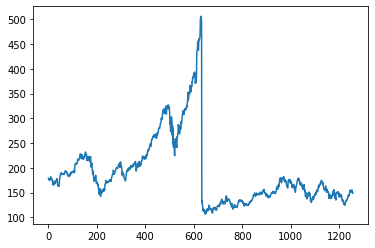

In [ ]:
plt.plot(df2) # values keep updating everyday

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1)) #LSTMs as sensitive to the scale of the data, so we are using MinMaxScaler
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(1257, 1)

In [ ]:
df2 #now it has been converted into an array of values between 0 and 1

array([[0.18066374],
       [0.17921102],
       [0.17853475],
       ...,
       [0.11448967],
       [0.10429555],
       [0.10537257]])

**Splitting Dataset - Training and Testing**

In [ ]:
#Splitting our dataset into Train and Test Dataset
training_size =  int(len(df2)*0.8)
test_size = len(df2) - training_size
train_data, test_data = df2[0:training_size,:], df2[training_size:len(df2),:1]

In [ ]:
training_size, test_size

(1005, 252)

In [ ]:
len(train_data), len(test_data)

(1005, 252)

**Data Pre-Processing**

In [ ]:
# Function for the Set of Values to Dataset Matrix Conversion
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX), np.array(dataY)

In [ ]:
# Dataset Matrix formation
time_step=100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(Y_train.shape)

(904, 100)
(904,)


(None, None)

In [ ]:
print(X_test.shape), print(Y_test.shape)

(151, 100)
(151,)


(None, None)

In [ ]:
#reshape input to be 3 dimensional [samples, time steps, features] which is required for LSTM model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) #here, mainly X_train.shape[1] and 1 will be fed to the LSTM Model
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1) #here, mainly X_test.shape[1] and 1 will be fed to the LSTM Model

**Stacked LSTM Model**

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(100,1))) #1st Layer
model.add(LSTM(50, return_sequences = True)) #2nd Layer
model.add(LSTM(50)) #3rd Layer
model.add(Dense(1)) #Final Layer
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
15/15 [==============================] - 12s 307ms/step - loss: 0.0301 - val_loss: 5.4626e-04
Epoch 2/100
15/15 [==============================] - 4s 299ms/step - loss: 0.0117 - val_loss: 4.1723e-04
Epoch 3/100
15/15 [==============================] - 3s 211ms/step - loss: 0.0082 - val_loss: 4.1475e-04
Epoch 4/100
15/15 [==============================] - 3s 208ms/step - loss: 0.0071 - val_loss: 4.8033e-04
Epoch 5/100
15/15 [==============================] - 4s 243ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 6/100
15/15 [==============================] - 4s 251ms/step - loss: 0.0061 - val_loss: 8.2964e-04
Epoch 7/100
15/15 [==============================] - 3s 212ms/step - loss: 0.0055 - val_loss: 5.5745e-04
Epoch 8/100
15/15 [==============================] - 3s 212ms/step - loss: 0.0049 - val_loss: 3.1344e-04
Epoch 9/100
15/15 [==============================] - 4s 294ms/step - loss: 0.0042 - val_loss: 3.1048e-04
Epoch 10/100
15/15 [==============================] - 3s 2

In [ ]:
import tensorflow as tf
tf.__version__

'2.11.0'

**Prediction (Predict the Output)**

In [ ]:
# Prediction and Performance Metrics Check
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 49ms/step


In [ ]:
# Transform back to Original Form (currently values are scaled)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Calculating Root Mean Squared Error Performance Metrics
math.sqrt(mean_squared_error(Y_train, train_predict))

213.88417289019597

In [ ]:
# Test Data Root Mean Squared Error
math.sqrt(mean_squared_error(Y_test, test_predict))

146.66424576911544

**Plotting the Predicted Output**

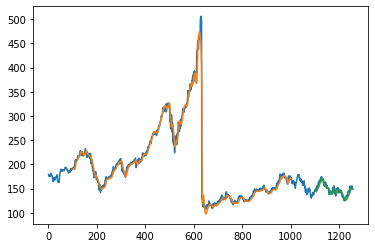

In [ ]:
# Shift Train Predictions for Plotting
look_back = 100
train_Predict_Plot = np.empty_like(df2)
train_Predict_Plot[:,:] = np.nan
train_Predict_Plot[look_back : len(train_predict)+look_back, :] = train_predict

# Shift Test Predictions for Plotting
test_Predict_Plot = np.empty_like(df2)
test_Predict_Plot[:,:] = np.nan
test_Predict_Plot[len(train_predict)+(look_back*2)+1 : len(df2)-1, :] = test_predict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(train_Predict_Plot)
plt.plot(test_Predict_Plot)
plt.show()

# Green Line -- Predicted Data
# Orange Line -- Trained Data

 **Prediction (for future ie. next 30 days)**

In [ ]:
len(test_data)

252

In [ ]:
x_input = test_data[152:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
# conversion to list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
# demonstrate prediction for 30 days
lst_output = []
n_steps = 100
i = 0

while(i<30):
  if(len(temp_input)>100):
    print(temp_input)
    x_input = np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape(1,n_steps,1)
    print(x_input) 
    yhat = model.predict(x_input, verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    print(temp_input)
    lst_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i = i+1

print(lst_output)

[0.10938986]
101
[0.08926737633061982, 0.07854727614276763, 0.08919223544145266, 0.09833437695679392, 0.09908578584846583, 0.09665623043206006, 0.08328115216030052, 0.08410770194113959, 0.08050093926111451, 0.07889793362554787, 0.09054477144646211, 0.07899812147777074, 0.08909204758922978, 0.0924483406386975, 0.09272385723231058, 0.09154664996869122, 0.1012648716343143, 0.10672510958046327, 0.11396368190356915, 0.10647463994990602, 0.09507827175954914, 0.1224796493425172, 0.11646837820914213, 0.10973074514715087, 0.0956543519098309, 0.08025046963055726, 0.07899812147777074, 0.08035065748278014, 0.08180338134001247, 0.07020663744520972, 0.10026299311208514, 0.10735128365685653, 0.103794614902943, 0.10820288040075132, 0.10507201001878513, 0.10990607388854096, 0.11133375078271751, 0.10311834690043825, 0.10855353788353161, 0.11078271759549146, 0.10336881653099561, 0.09362554790231681, 0.08598622417031926, 0.10316844082654975, 0.10386975579211016, 0.1026174076393237, 0.0996618659987476, 0.0

In [ ]:
new_day = np.arange(1,101) # old 100 days data
day_pred = np.arange(101,131) #for the 30 days prediction in the future

In [ ]:
len(df2)

1257

In [ ]:
df3 = df2.tolist()
df3.extend(lst_output)

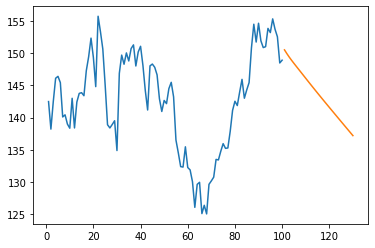

In [ ]:
plt.plot(new_day, scaler.inverse_transform(df2[1157:])) #1157 because we are considering only the previous 100 days data
plt.plot(day_pred, scaler.inverse_transform(lst_output))

#orange line here indicates the nature of the stock's closing price for the next 30 days (in the future)

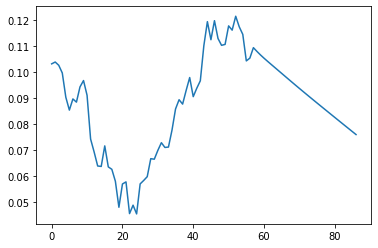

In [ ]:
df3 = df2.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

*A Project by* **ABHISHT MISHRA (12011843)** 